In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import numpy as np
from inspect_utils.viz import make_confusion_matrix
from pprint import pprint
import warnings
import cv2
warnings.filterwarnings('ignore')

# Cutout counts (with bad batches)

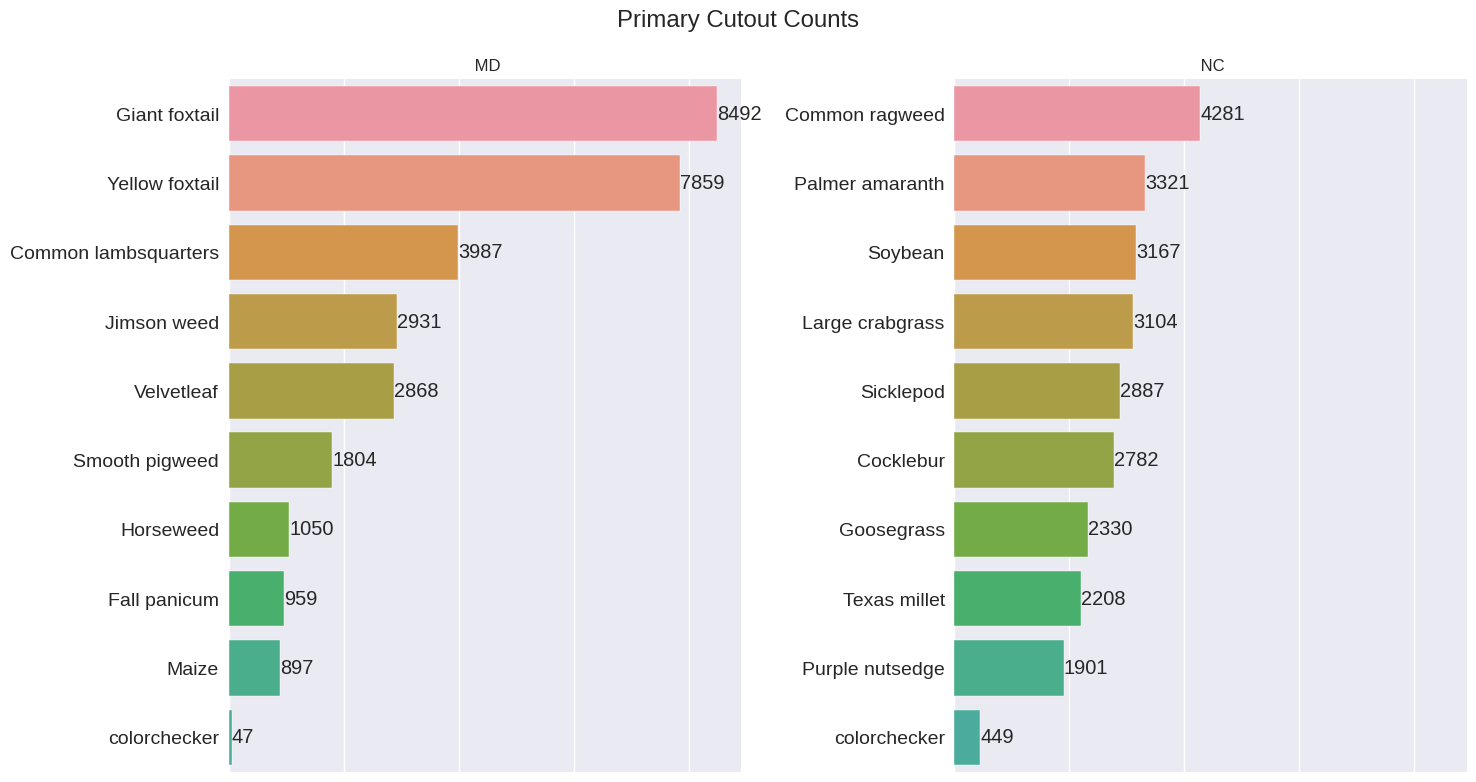

In [28]:
df = pd.read_csv("../SemiF-InspectCutouts/data/summer_weeds_2022/summer_weeds_2022.csv", low_memory=False)
bad_batches = [
    "MD_2022-06-28", "MD_2022-07-01", "MD_2022-07-06", "MD_2022-10-11",
    "NC_2022-08-09", "NC_2022-08-10", "NC_2022-08-15", "NC_2022-08-17",
    "NC_2022-08-26", "NC_2022-08-30", "NC_2022-09-07", "NC_2022-09-09",
    "NC_2022-09-12", "NC_2022-10-11", "NC_2022-10-13", "NC_2022-10-17"
]
df = df[~df.batch_id.isin(bad_batches)]
md = df[df["state_id"] == "MD"]
nc = df[df["state_id"] == "NC"]

with plt.style.context('seaborn-v0_8-notebook'):
    sns.set(font_scale=1.2)  #
    dfgb = df.groupby([
        'common_name', 'state_id'
    ])['cutout_id'].count().reset_index(name='Count').sort_values(['Count'],
                                                                ascending=False)
    plt.style.use('seaborn')
    g = sns.catplot(data=dfgb,
                    y="common_name",
                    x="Count",
                    kind="bar",
                    col="state_id",
                    sharey=False,
                    margin_titles=True)
    g.fig.set_size_inches(15, 8)
    g.fig.subplots_adjust(top=0.9)

    # g.fig.suptitle('Unique cutout count')
    g.set_titles("{row_name}")#, fontdict={'fontsize':14})
    # iterate through axes
    for ax in g.axes.ravel():
        title = ax.get_title().split("=")[1]
        ax.set_title(title)
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # add annotations
        for c in ax.containers:
            labels = [f'{int(v.get_width())}' for v in c]
            ax.bar_label(
                c,
                labels=labels,
                label_type="edge",
            )
    g.set_axis_labels("", "")
    g.set(xticklabels=[]) 
    plt.suptitle("Primary Cutout Counts")
    plt.tight_layout()
    plt.savefig("Primary Cutout Counts.png", dpi=150)
    plt.show()

In [29]:
nc.groupby(["common_name"])["common_name"].count().sort_values()

common_name
colorchecker        449
Purple nutsedge    1901
Texas millet       2208
Goosegrass         2330
Cocklebur          2782
Sicklepod          2887
Large crabgrass    3104
Soybean            3167
Palmer amaranth    3321
Common ragweed     4281
Name: common_name, dtype: int64

common_name
colorchecker        449
Purple nutsedge    1901
Texas millet       2208
Goosegrass         2330
Cocklebur          2782
Sicklepod          2887
Large crabgrass    3104
Soybean            3167
Palmer amaranth    3321
Common ragweed     4281
Name: common_name, dtype: int64

In [13]:
path = "../SemiF-InspectCutouts/data/summer_weeds_2022/inspection_results__02:20:11 12-11-2022__11295 of 11295__completed_FINAL.csv"
df = pd.read_csv(path, low_memory=False)

df["true_species"] = np.where(df["true_species"] == "True", df["common_name"],
                              df["true_species"])


md = df[df["state_id"] == "MD"]
nc = df[df["state_id"] == "NC"]

# Evaluation Overview

* Manually inspected 11,300 primary cutouts
* Sampled a maximum of 30 cutouts for each species, for each batch.
* Each cutout was manually labaled. 
* Manual and infered labels were compared. 

# 1. Overall Batch Accuracy
Looking at batch accuracy leads us to inconsistencies in accuracy.

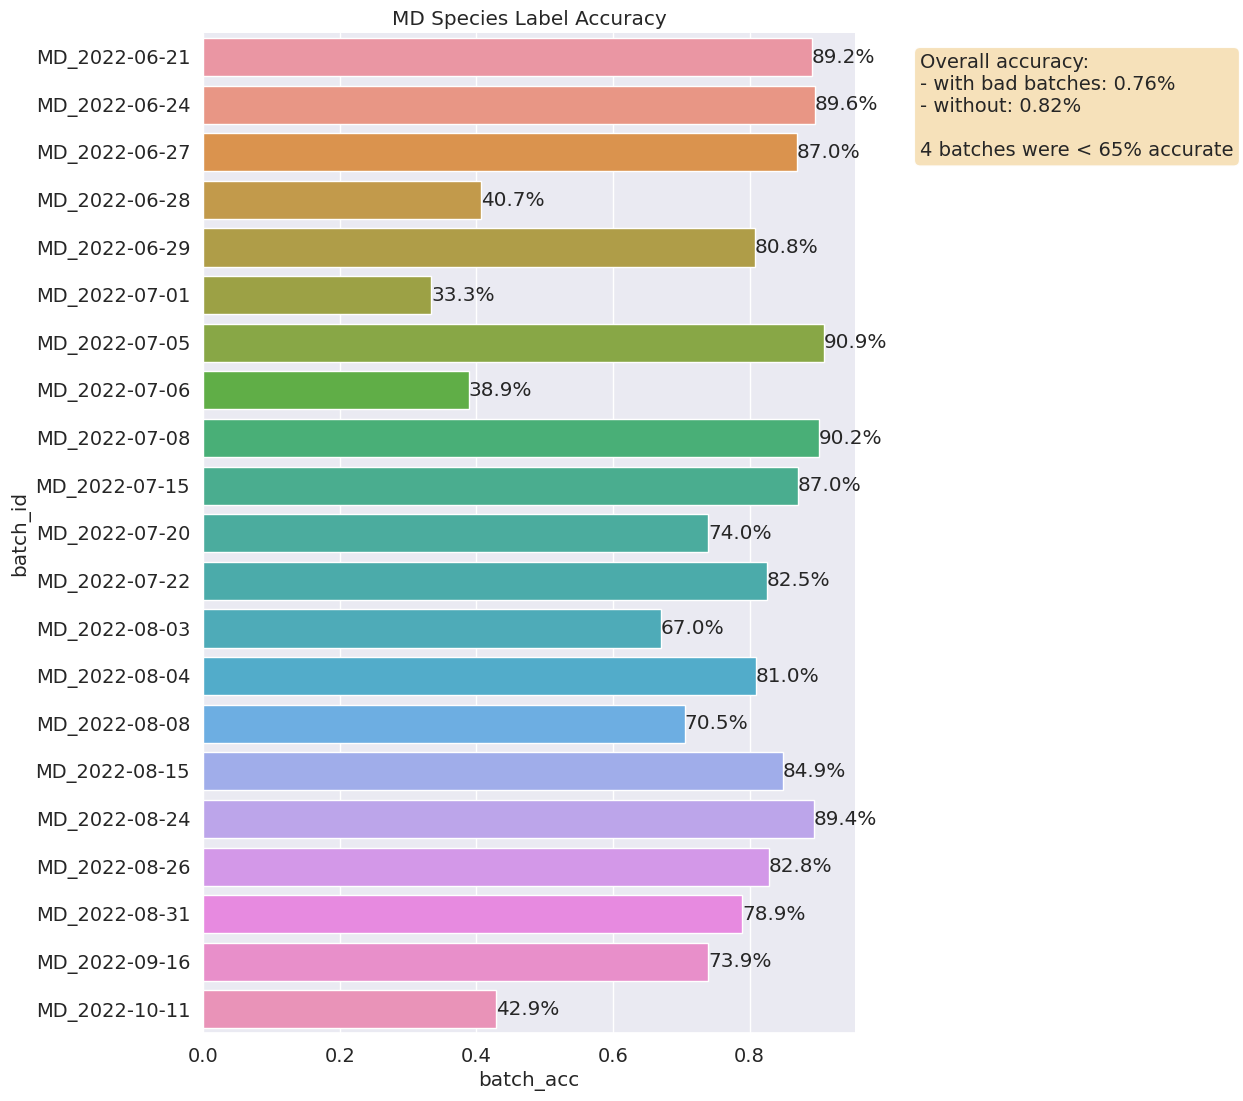

In [10]:
# Read inspection data
path = "../SemiF-InspectCutouts/data/summer_weeds_2022/inspection_results__02:20:11 12-11-2022__11295 of 11295__completed_FINAL.csv"
df = pd.read_csv(path, low_memory=False)
# Cleaning: Replace True with common_name
df["true_species"] = np.where(df["true_species"] == "True", df["common_name"],
                              df["true_species"])
# Get MD data
md = df[df["state_id"] == "MD"]
# Ignore unknowns
md_ex = md[~md.common_name.isin(["unknown"])]
dfs = []
for batch in md.batch_id.unique():
    tnc = md[md["batch_id"] == batch]
    tnc_true = tnc["true_species"]
    tnc_pred = tnc["common_name"]

    clf_report = classification_report(tnc_true,
                                       tnc_pred,
                                       zero_division=0,
                                       output_dict=True)
    bdf = pd.DataFrame(clf_report).T  #iloc[:-1, :].T
    bdf["batch_id"] = batch
    bdf["batch_acc"] = clf_report["accuracy"]
    bdf["mac_avg_prec"] = bdf.loc["macro avg", "precision"]
    bdf["mac_avg_recall"] = bdf.loc["macro avg", "recall"]
    bdf["mac_avg_f1-score"] = bdf.loc["macro avg", "f1-score"]
    bdf["weight_avg_prec"] = bdf.loc["weighted avg", "precision"]
    bdf["weight_avg_recall"] = bdf.loc["weighted avg", "recall"]
    bdf["weight_avg_f1-score"] = bdf.loc["weighted avg", "f1-score"]
    bdf = bdf.drop(index=["accuracy", "macro avg", "weighted avg"])
    dfs.append(bdf)

res = pd.concat(dfs).reset_index(names="species")
wo_bbatch_res = res[~res.batch_id.isin(bad_batches)]
sns.set(font_scale=1.2)
g = sns.catplot(res,
                y="batch_id",
                x="batch_acc",
                kind="bar",
                height=11,
                aspect=.8)
# extract the matplotlib axes_subplot objects from the FacetGrid
for ax in g.axes.ravel():
    ax.tick_params(axis='both', which='major', labelsize=14)
    # place a text box in upper left in axes coords

    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_width() * 100):.1f}%' for v in c]
        ax.bar_label(
            c,
            labels=labels,
            label_type="edge",
        )

# Calculate overall accuracy
# Calculate overall accuracy
bad_batches = list(res[res["batch_acc"] < .65]["batch_id"].unique())
# Get overall state accuracy
batch_true = md["true_species"]
batch_pred = md["common_name"]
batch_clf_report = classification_report(batch_true,
                                         batch_pred,
                                         zero_division=0,
                                         output_dict=True)
batch_state_accuracy = batch_clf_report["accuracy"]

# Ignore bad batches
wo_bbatch_md = md[~md.batch_id.isin(bad_batches)]
wo_bbatch_true = wo_bbatch_md["true_species"]
wo_bbatch_pred = wo_bbatch_md["common_name"]
wo_bbatch_clf_report = classification_report(wo_bbatch_true,
                                             wo_bbatch_pred,
                                             zero_division=0,
                                             output_dict=True)
wo_bbatch_state_accuracy = wo_bbatch_clf_report["accuracy"]

props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
text = f"Overall accuracy:\n- with bad batches: {batch_state_accuracy:.2f}%\n- without: {wo_bbatch_state_accuracy:.2f}%\n\n{len(bad_batches)} batches were < 65% accurate"
ax.text(1.10,
        0.98,
        text,
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment='top',
        bbox=props)

plt.title(f"MD Species Label Accuracy")
plt.savefig("Label accuracy MD.png", dpi=150)
plt.show()

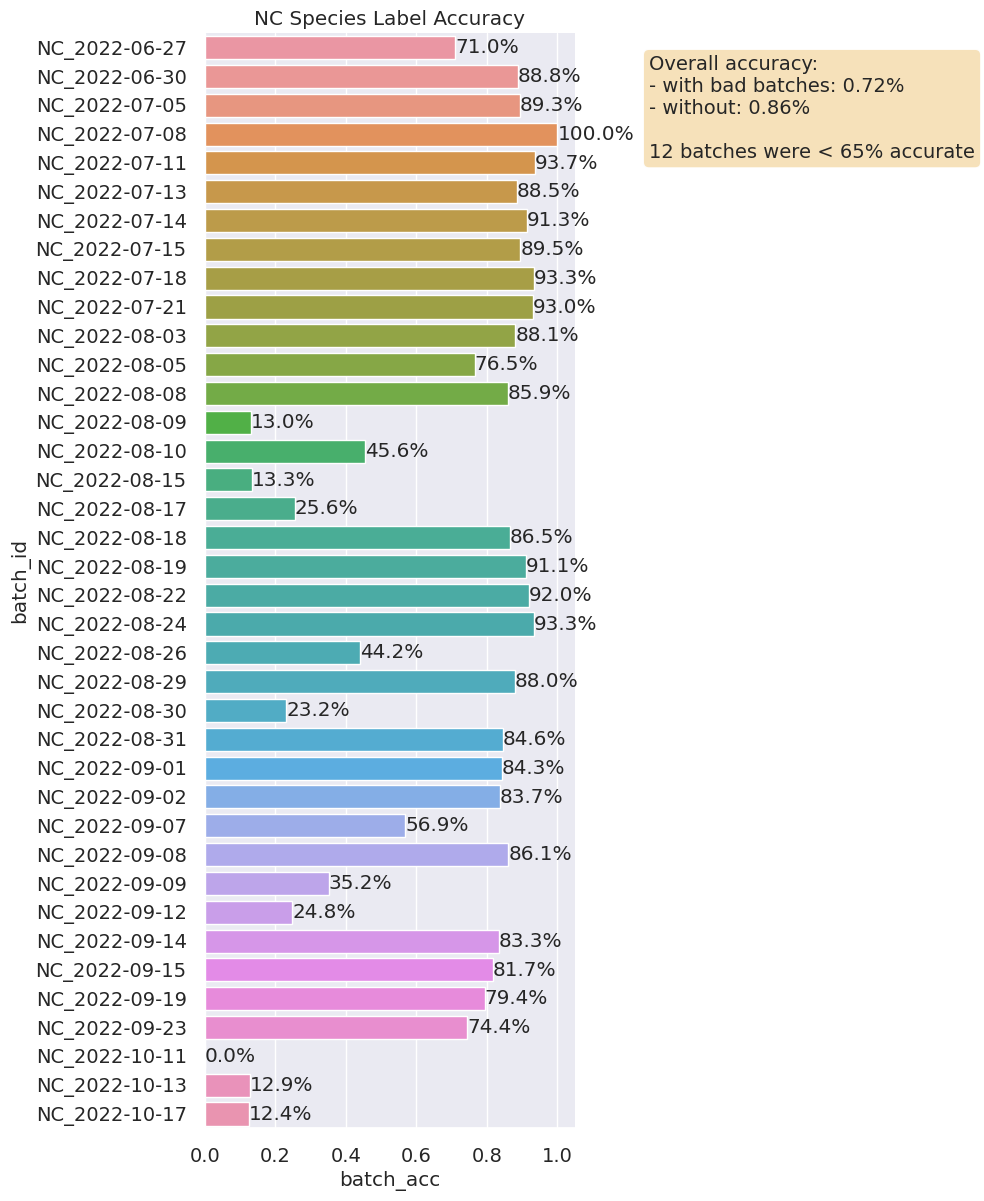

In [14]:
# Read inspection data
path = "../SemiF-InspectCutouts/data/summer_weeds_2022/inspection_results__02:20:11 12-11-2022__11295 of 11295__completed_FINAL.csv"
df = pd.read_csv(path, low_memory=False)
# Cleaning: Replace True with common_name
df["true_species"] = np.where(df["true_species"] == "True", df["common_name"],
                              df["true_species"])

# Get MD data
nc = df[df["state_id"] == "NC"]

dfs = []
for batch in nc.batch_id.unique():
    tnc = nc[nc["batch_id"] == batch]
    tnc_true = tnc["true_species"]
    tnc_pred = tnc["common_name"]

    clf_report = classification_report(tnc_true,
                                       tnc_pred,
                                       zero_division=0,
                                       output_dict=True)

    bdf = pd.DataFrame(clf_report).T  #iloc[:-1, :].T
    bdf["batch_id"] = batch
    bdf["batch_acc"] = clf_report["accuracy"]
    bdf["mac_avg_prec"] = bdf.loc["macro avg", "precision"]
    bdf["mac_avg_recall"] = bdf.loc["macro avg", "recall"]
    bdf["mac_avg_f1-score"] = bdf.loc["macro avg", "f1-score"]
    bdf["weight_avg_prec"] = bdf.loc["weighted avg", "precision"]
    bdf["weight_avg_recall"] = bdf.loc["weighted avg", "recall"]
    bdf["weight_avg_f1-score"] = bdf.loc["weighted avg", "f1-score"]
    bdf = bdf.drop(index=["accuracy", "macro avg", "weighted avg"])
    dfs.append(bdf)

nc_res = pd.concat(dfs).reset_index(names="species")
with plt.style.context('seaborn-v0_8-notebook'):
    sns.set(font_scale=1.2)
    g = sns.catplot(nc_res,
                    y="batch_id",
                    x="batch_acc",
                    kind="bar",
                    height=12,
                    aspect=.5)
    for ax in g.axes.ravel():
        ax.tick_params(axis='both', which='major', labelsize=14)
        # add annotations
        for c in ax.containers:
            labels = [f'{(v.get_width() * 100):.1f}%' for v in c]
            ax.bar_label(
                c,
                labels=labels,
                label_type="edge",
            )

    # Calculate overall accuracy
    nc_bad_batches = list(nc_res[nc_res["batch_acc"] < .65]["batch_id"].unique())
    # Get overall state accuracy
    batch_true = nc["true_species"]
    batch_pred = nc["common_name"]
    batch_clf_report = classification_report(batch_true,
                                             batch_pred,
                                             zero_division=0,
                                             output_dict=True)
    batch_state_accuracy = batch_clf_report["accuracy"]

    # Ignore bad batches
    wo_bbatch_nc = nc[~nc.batch_id.isin(nc_bad_batches)]
    wo_bbatch_true = wo_bbatch_nc["true_species"]
    wo_bbatch_pred = wo_bbatch_nc["common_name"]
    wo_bbatch_clf_report = classification_report(wo_bbatch_true,
                                                 wo_bbatch_pred,
                                                 zero_division=0,
                                                 output_dict=True)
    wo_bbatch_state_accuracy = wo_bbatch_clf_report["accuracy"]

    # Add text
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    text = f"Overall accuracy:\n- with bad batches: {batch_state_accuracy:.2f}%\n- without: {wo_bbatch_state_accuracy:.2f}%\n\n{len(nc_bad_batches)} batches were < 65% accurate"
    ax.text(1.20,
            0.98,
            text,
            transform=ax.transAxes,
            fontsize=14,
            verticalalignment='top',
            bbox=props)

    plt.title("NC Species Label Accuracy")
    plt.savefig("Label accuracy NC.png", dpi=150)
    plt.show()

In [37]:
print("Less then 65% accurate")
for x in nc_res[nc_res["batch_acc"] < 0.65]["batch_id"].unique():
    print(x)

Less then 65% accurate
NC_2022-08-09
NC_2022-08-10
NC_2022-08-15
NC_2022-08-17
NC_2022-08-26
NC_2022-08-30
NC_2022-09-07
NC_2022-09-09
NC_2022-09-12
NC_2022-10-13
NC_2022-10-17


### Why?

### AutoSfM results

#### Good

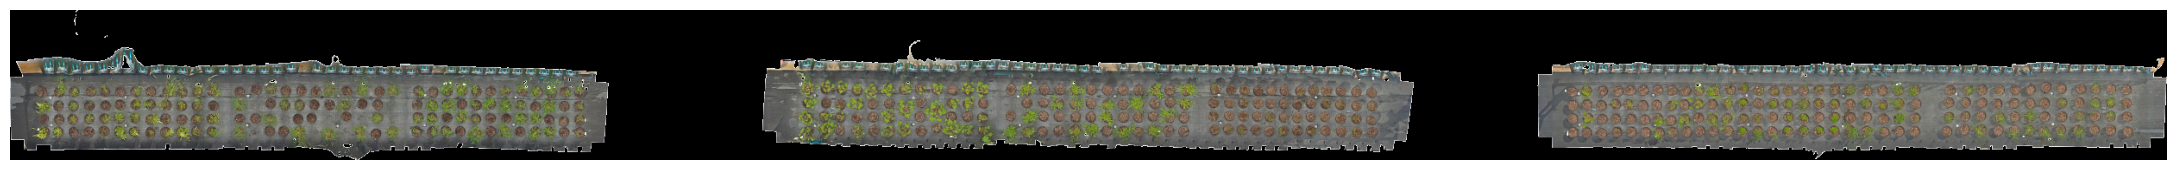

In [63]:
good = "/home/psa_images/Pipeline/SemiF-InspectCutouts/data/good_batches/NC_2022-09-14_preview.png"
im = cv2.cvtColor(cv2.imread(good), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(22,18))
plt.imshow(im)
plt.axis(False)
plt.tight_layout()
plt.show()

#### Bad

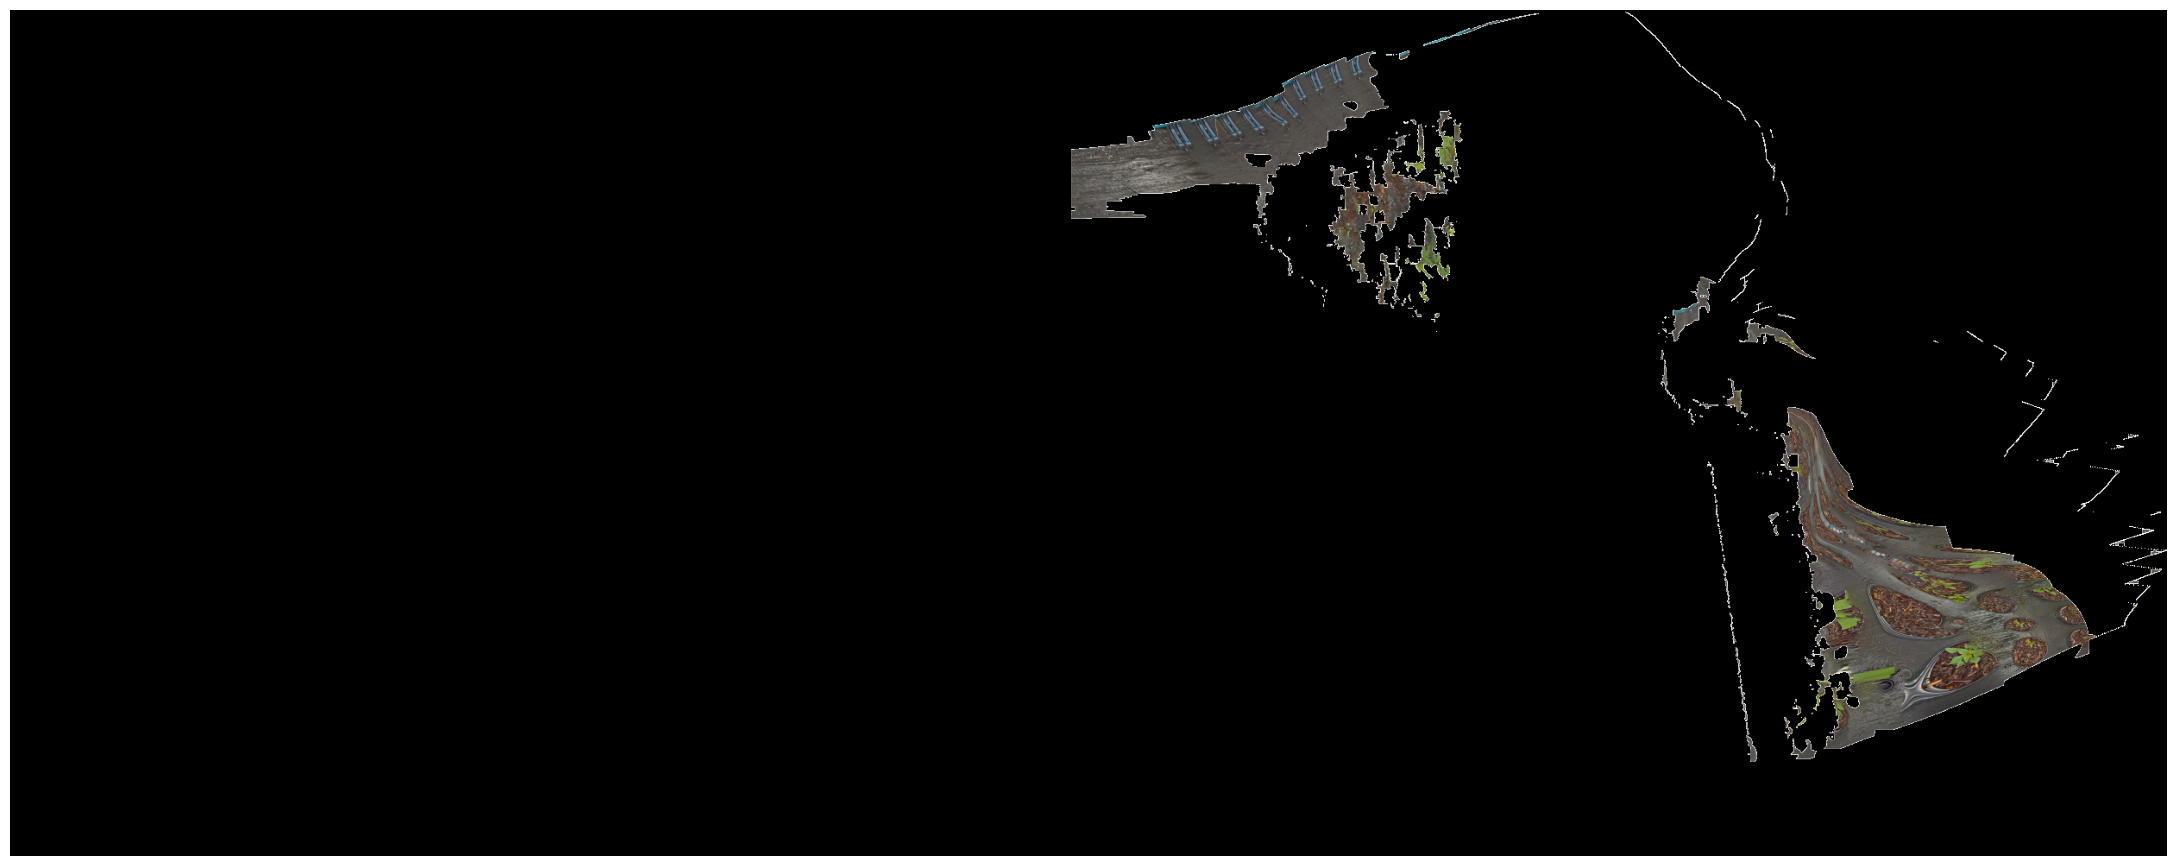

In [66]:
bad = "/home/psa_images/Pipeline/SemiF-InspectCutouts/data/bad_batches/NC_2022-08-15_preview.png"
im = cv2.cvtColor(cv2.imread(bad), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(22,18))
plt.imshow(im)
plt.axis(False)
plt.tight_layout()
plt.show()

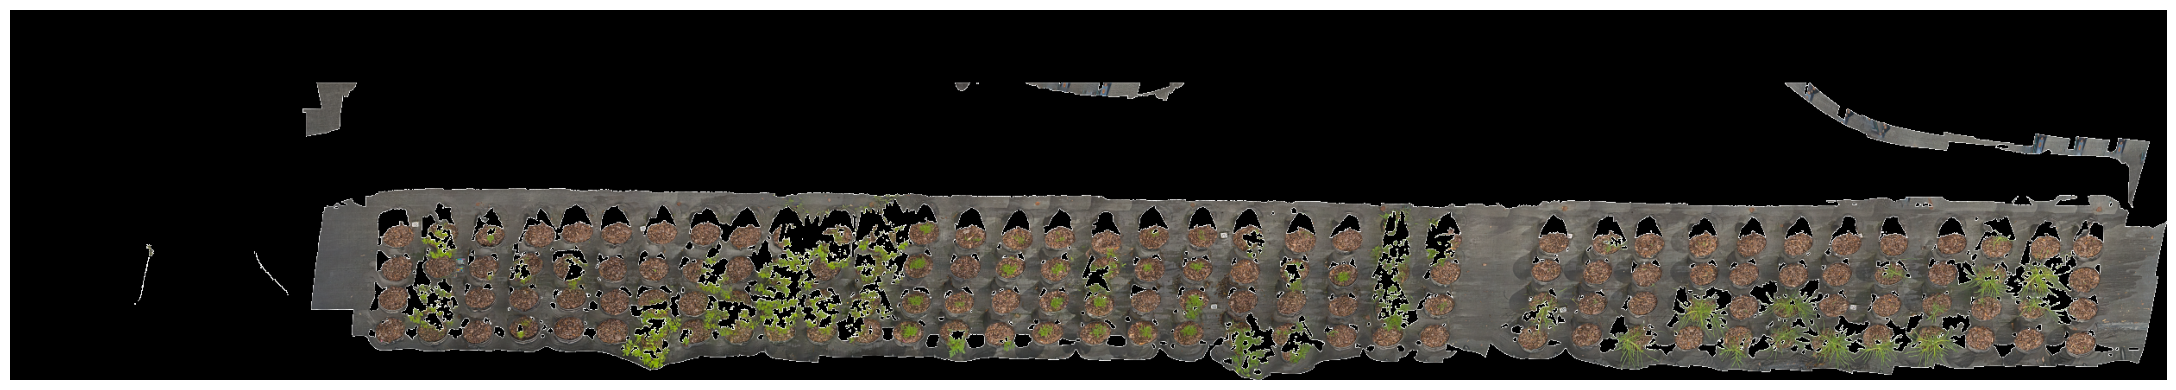

In [67]:
bad = "/home/psa_images/Pipeline/SemiF-InspectCutouts/data/bad_batches/NC_2022-09-09_preview.png"
im = cv2.cvtColor(cv2.imread(bad), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(22,18))
plt.imshow(im)
plt.axis(False)
plt.tight_layout()
plt.show()

## Improve AutoSfM results by:

Processing: 
1. Running at higher resolutions 


On the ground: 
1. Making sure flash is working
2. improving marker positions
3. and use proper background material

# 2. Evalute "weediness" (target vs non-target weed)


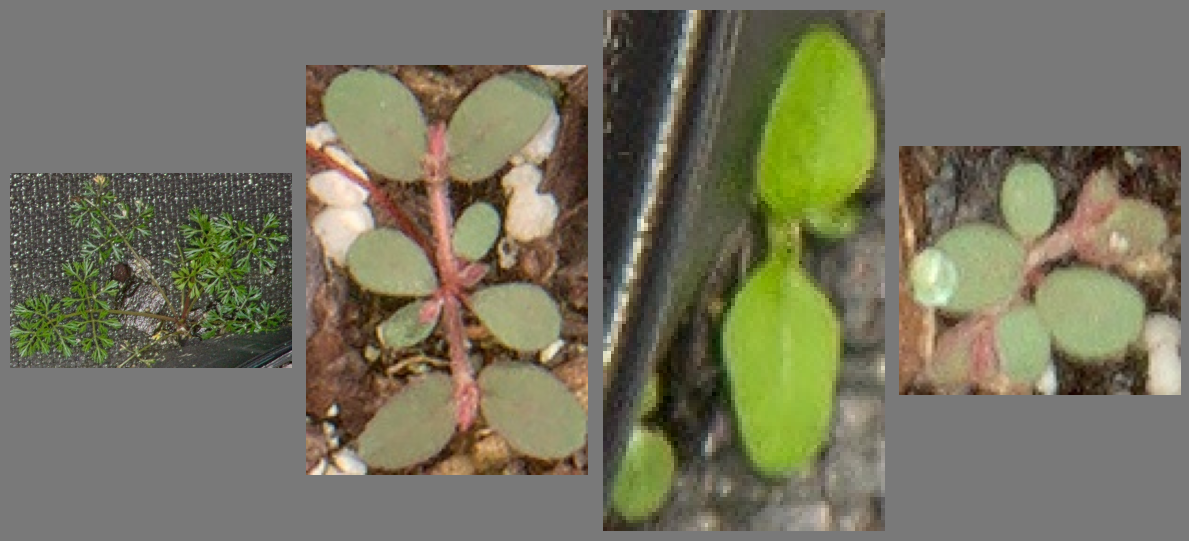

In [38]:
import random
# randint = random.randint(0,1000)
# print(randint)
dfex = df[~df.batch_id.isin(bad_batches)]

samp = df[df["true_species"]=="weed"].sample(4, random_state=62)
cnames = samp["common_name"]
imgs = list(samp["temp_cropout_path"])
f, axs = plt.subplots(1, 4, figsize=(12,8))
f.patch.set_facecolor('black')
f.patch.set_alpha(0.52)

axs[0].imshow(cv2.cvtColor(cv2.imread(imgs[0]), cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(cv2.imread(imgs[1]), cv2.COLOR_BGR2RGB))
axs[2].imshow(cv2.cvtColor(cv2.imread(imgs[2]), cv2.COLOR_BGR2RGB))
axs[3].imshow(cv2.cvtColor(cv2.imread(imgs[3]), cv2.COLOR_BGR2RGB))

axs[0].axis(False)
plt.tight_layout()
axs[1].axis(False)
plt.tight_layout()
axs[2].axis(False)
plt.tight_layout()
axs[3].axis(False)
plt.tight_layout()
plt.show()

# Identify non-target weeds

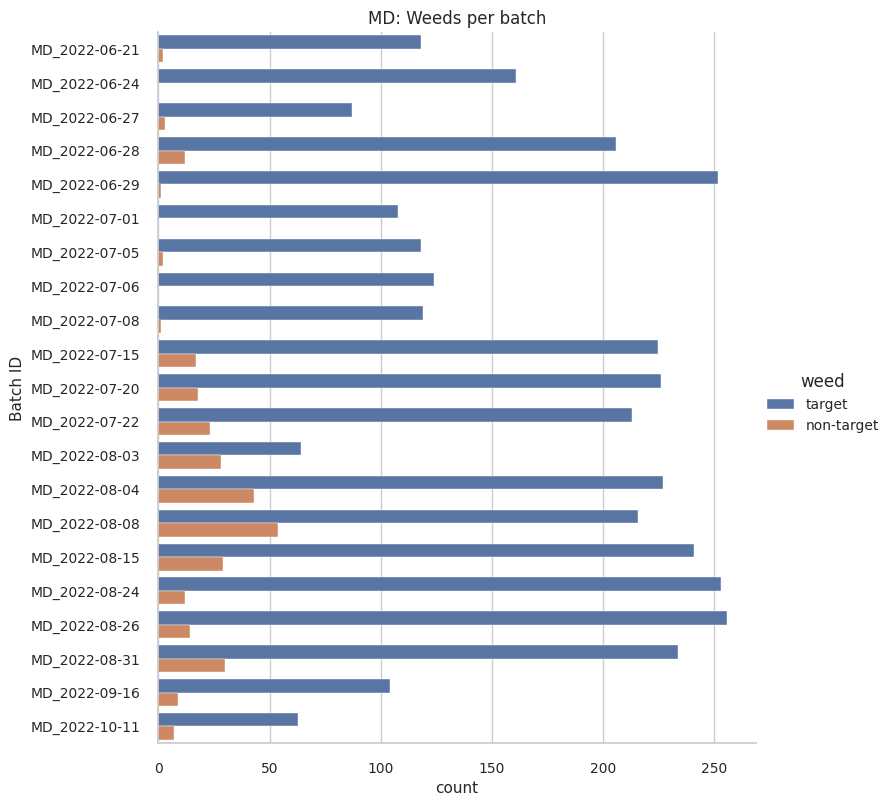

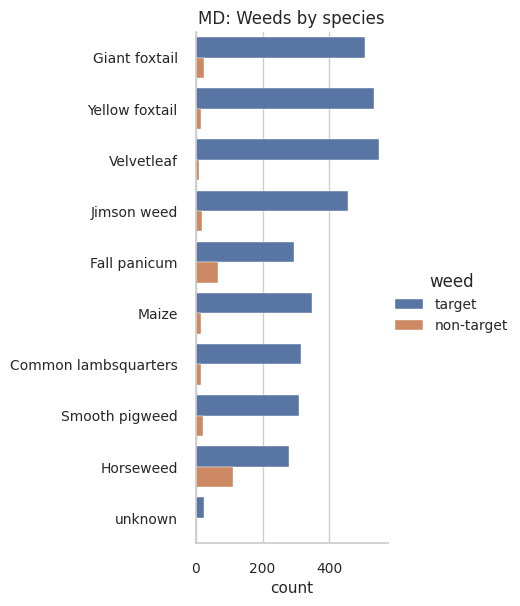

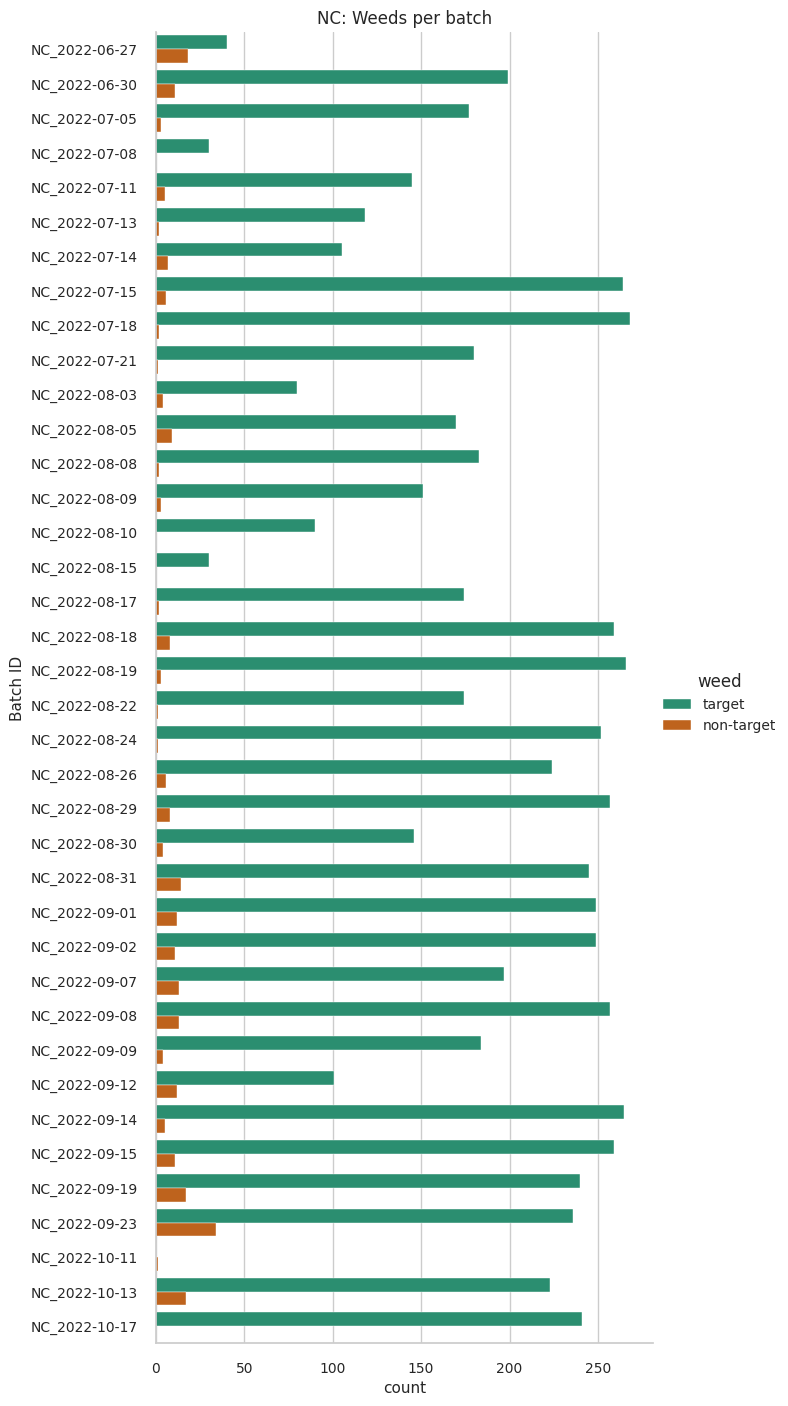

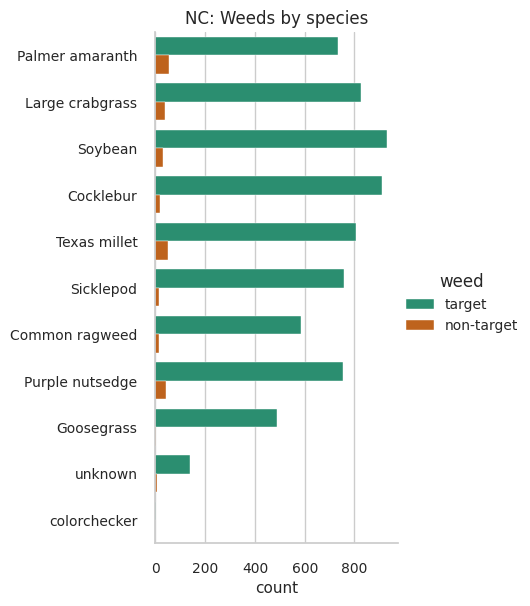

In [80]:
dfc = df.copy()
dfc = dfc[~dfc.true_species.isin(["unknown", "colorchecker"])]
dfc["weed"] = np.where(dfc["true_species"]=="weed", "non-target", "target")
dfc["binary_pred"] = "target"

md = dfc[dfc["state_id"] == "MD"]
nc = dfc[dfc["state_id"] == "NC"]

with plt.style.context('seaborn-v0_8-notebook'):
    g = sns.catplot(md, y="batch_id", kind="count", hue="weed", height=8, aspect=1)
    g.set_axis_labels(y_var="Batch ID")  # use this argument literally
    plt.title("MD: Weeds per batch")
    plt.savefig("Nontarget weeds by batch MD.png", dpi=150)
    plt.show()

with plt.style.context('seaborn-v0_8-notebook'):
    g = sns.catplot(md, y="common_name", kind="count", hue="weed", height=6, aspect=.8)
    g.set_axis_labels(y_var="")  # use this argument literally
    plt.title("MD: Weeds by species")
    plt.savefig("Nontarget weeds by species MD.png", dpi=150)
    plt.show()

with plt.style.context('seaborn-v0_8-notebook'):
    g = sns.catplot(nc, y="batch_id", kind="count", hue="weed", height=14, aspect=.5, palette="Dark2")
    g.set_axis_labels(y_var="Batch ID")  # use this argument literally
    plt.title("NC: Weeds per batch")
    plt.savefig("Nontarget weeds by batch NC.png", dpi=150)
    plt.show()

with plt.style.context('seaborn-v0_8-notebook'):
    g = sns.catplot(nc, y="common_name", kind="count", hue="weed", height=6, aspect=.8, palette="Dark2")
    g.set_axis_labels(y_var="")  # use this argument literally
    plt.title("NC: Weeds by species")
    plt.savefig("Nontarget weeds by species NC.png", dpi=150)
    plt.show()

# 3. Species Accuracy (F1-score) with and without bad batches

In [15]:
# nc_spec = nc_res[nc_res["batch_acc"] > 0.65]
# print(nc_spec.columns)
# plt.style.available
nc_bad_batches = list(nc_res[nc_res["batch_acc"] < 0.65]["batch_id"].unique())



# nc_res["is_bad_batch"] = np.where(nc_res.batch_id.isin(nc_bad_batches).astype(str)=="True", "bad", "good")
# nc_spec = nc_spec[~nc_res.species.isin(["unknown", "weed"])]
# nc_spec.columns
# nc_spec["is_batch_bad"] = nc_res.batch_id.isin(nc_bad_batches)
# nc_spec["is_batch_bad"]
nc_spec = nc_res.copy()
nc_spec["is_batch_bad"] = np.where(nc_res.batch_id.isin(nc_bad_batches)==True, "bad", "good")



In [16]:
nc_bad_batches = list(nc_res[nc_res["batch_acc"] < 0.65]["batch_id"].unique())
nc_res[nc_res.batch_id.isin(nc_bad_batches)]

,species,precision,recall,f1-score,support,batch_id,batch_acc,mac_avg_prec,mac_avg_recall,mac_avg_f1-score,weight_avg_prec,weight_avg_recall,weight_avg_f1-score
107,Cocklebur,0.0,0.0,0.0,43.0,NC_2022-08-09,0.129870,0.065152,0.059848,0.056982,0.192316,0.129870,0.151386
108,Common ragweed,0.0,0.0,0.0,2.0,NC_2022-08-09,0.129870,0.065152,0.059848,0.056982,0.192316,0.129870,0.151386
109,Goosegrass,0.0,0.0,0.0,17.0,NC_2022-08-09,0.129870,0.065152,0.059848,0.056982,0.192316,0.129870,0.151386
110,Large crabgrass,0.0,0.0,0.0,10.0,NC_2022-08-09,0.129870,0.065152,0.059848,0.056982,0.192316,0.129870,0.151386
111,Palmer amaranth,0.0,0.0,0.0,10.0,NC_2022-08-09,0.129870,0.065152,0.059848,0.056982,0.192316,0.129870,0.151386
...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,Palmer amaranth,0.0,0.0,0.0,0.0,NC_2022-10-17,0.124481,0.111111,0.013831,0.024600,1.000000,0.124481,0.221402
351,Purple nutsedge,0.0,0.0,0.0,0.0,NC_2022-10-17,0.124481,0.111111,0.013831,0.024600,1.000000,0.124481,0.221402
352,Sicklepod,0.0,0.0,0.0,0.0,NC_2022-10-17,0.124481,0.111111,0.013831,0.024600,1.000000,0.124481,0.221402
353,Soybean,0.0,0.0,0.0,0.0,NC_2022-10-17,0.124481,0.111111,0.013831,0.024600,1.000000,0.124481,0.221402


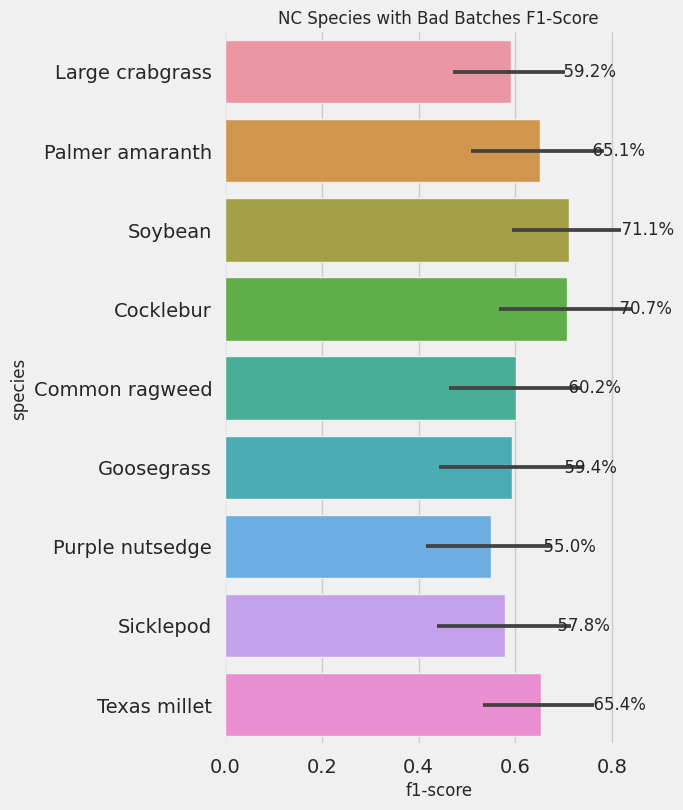

In [66]:
nc_spec = nc_spec[~nc_spec.isin(["unknown", "weed", "colorchecker"])]

# nc_bad_batches = list(nc_res[nc_res["batch_acc"] < 0.65]["batch_id"].unique())
# nc_res["is_bad_batch"] = np.where(nc_res.batch_id.isin(nc_bad_batches), "bad", "good")
nc_spec_wo_bbatches = nc_spec[~nc_spec.batch_id.isin(nc_bad_batches)]

with plt.style.context('fivethirtyeight'):
    sns.set_context("notebook")
    
    g=sns.catplot(nc_spec, y="species", x="f1-score", kind="bar", height=8, aspect=.8)
    
    for ax in g.axes.ravel():
        ax.tick_params(axis='both', which='major', labelsize=14)
        # add annotations
        for c in ax.containers:
            labels = [f'          {(v.get_width() * 100):.1f}%' for v in c]
            ax.bar_label(
                c,
                labels=labels,
            )

    plt.title("NC Species with Bad Batches F1-Score")
    plt.show()

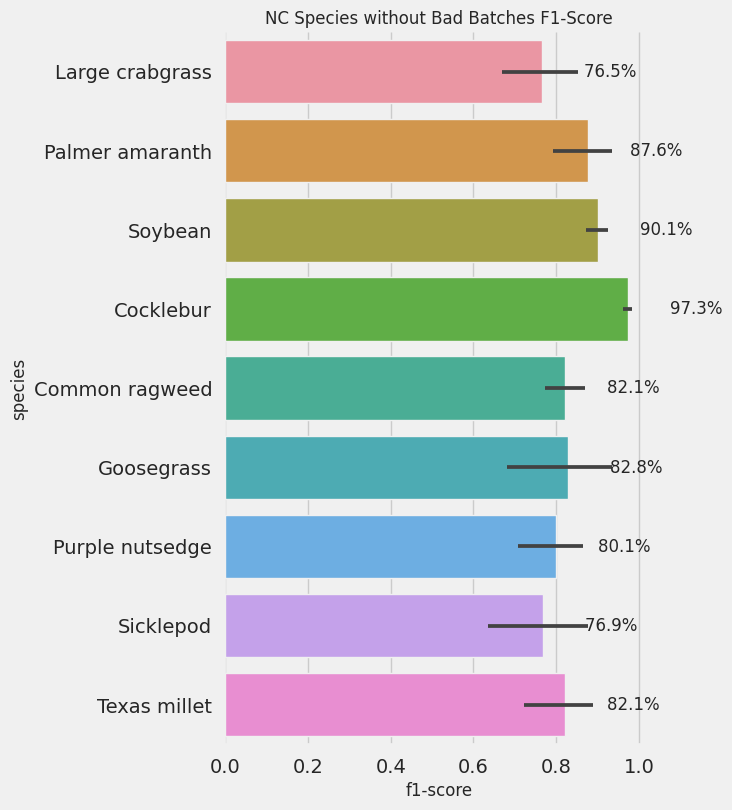

In [11]:
nc_spec = nc_spec[~nc_spec.isin(["unknown", "weed", "colorchecker"])]

# nc_bad_batches = list(nc_res[nc_res["batch_acc"] < 0.65]["batch_id"].unique())
# nc_res["is_bad_batch"] = np.where(nc_res.batch_id.isin(nc_bad_batches), "bad", "good")
nc_spec_wo_bbatches = nc_spec[~nc_spec.batch_id.isin(nc_bad_batches)]

with plt.style.context('fivethirtyeight'):
    sns.set_context("notebook")
    
    g=sns.catplot(nc_spec_wo_bbatches, y="species", x="f1-score", kind="bar", height=8, aspect=.8)
    
    for ax in g.axes.ravel():
        ax.tick_params(axis='both', which='major', labelsize=14)
        # add annotations
        for c in ax.containers:
            labels = [f'        {(v.get_width() * 100):.1f}%' for v in c]
            ax.bar_label(
                c,
                labels=labels,
            )

    plt.title("NC Species without Bad Batches F1-Score")
    plt.show()